<img src = '../docs/qdart.png' height = '400px'>

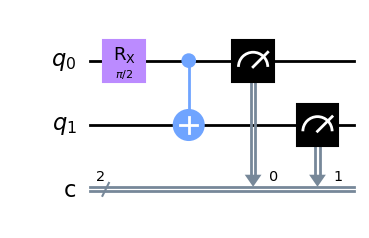

In [1]:
import pennylane as qml
from qiskit.tools.visualization import circuit_drawer
import numpy as np 

dev = qml.device("qiskit.aer", wires=2)

@qml.qnode(dev)
def circuit(x,qiskit=False):
    qml.RX(x, wires=0)
    qml.CNOT(wires=[0,1])
    return qml.expval(qml.PauliZ(0))

circuit(np.pi/2,True)

circuit_drawer(dev._circuit,output='mpl')



In [6]:
import pickle 
with open("/home/viet/EvolutionalQuantumCircuit/codes/qiskitob.pickle","rb") as handle:
    qcirc = pickle.load(handle)


In [9]:
from qiskit import QuantumCircuit
import qtm.qcompilation
num_qubits = 3
preset = [7,1]
cset = [('RY', 0), ('RY', 1), ('RY', 2), ('CNOT', 0, 1), ('CNOT', 1, 0), ('CNOT', 0, 2), ('CNOT', 2, 0), ('Hadamard', 0), ('Hadamard', 1), ('Hadamard', 2)]
pnnp = [0,0]
theta = 0.6
qc = QuantumCircuit(3, 3)
qc.h(0)
qc.h(2)
qc.cx(0, 1)
compiler = qtm.qcompilation.QuantumCompilation(
    u = qc,
    vdagger = qtm.state.create_ghz_state(num_qubits).inverse(),
    optimizer = 'adam',
    loss_func = 'loss_fubini_study'
)
compiler.fit(num_steps = 100, verbose = 1)
compiler.loss_values[-1]

Step: 100%|██████████| 100/100 [00:01<00:00, 64.10it/s]


0.7061161377563893

In [2]:
import qiskit 
import qtm 

counts = qiskit.execute(
    dev._circuit, backend=qtm.constant.backend,
    shots=qtm.constant.num_shots).result().get_counts()
counts 

AttributeError: module 'qtm' has no attribute 'constant'

In [2]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')
job = backend.run(dev._circuit)
result = job.result()
outputstate = result.get_statevector(dev._circuit, decimals=3)
print(outputstate)

Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))


- qdas search thì sẽ trả về 1 mạch u nhưng mình sẽ đặt vấn đề là có cần concat mạch u vào mạch cũ hay ko?
- action của policy gradient có thể là 0 hoặc 1, có concat hoặc ko concat
- state s_t của policy gradient là circuit_old, s_t+1 là circuit mới
- nhưng hàm policy pi thì sẽ là 1 neural network pi(s_t) để encode state
- Mỗi state, dqas dùng hàm phân bố p(k=j,a) để chọn layer tạo mạch
- nhưng em xem thì dùng shapeley value có vẻ hiệu quả và phù hợp với context này (vì tham số a của qdas hiện giờ nó ko phụ thuộc vào cấu trúc cổng trong mạch và phụ thuộc loss)
- nên mình có thể tối ưu 2 vòng, 1 vòng tạo mạch u, 1 vòng ráp mạch u vào

In [2]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import qtm.dag
import qiskit
%load_ext autoreload
%autoreload 2
torch.manual_seed(1000)
torch.cuda.manual_seed(1000)
np.random.seed(1000)
random.seed(1000)

qc = qiskit.QuantumCircuit(3)
qc.h(0)
qc.h(2)
qc.cx(0, 1)
qc.measure_all()
dag = qtm.dag.circuit_to_dag(qc)
node_features = qtm.dag.dag_to_node_features(dag)
adjacency_matrix = qtm.dag.dag_to_adjacency_matrix(dag)

print(node_features)
print(adjacency_matrix)
print(qtm.dag.circuit_to_scalar(qc))

[[ 7  0]
 [ 7  0]
 [25  0]]
[[0 0 1]
 [0 0 0]
 [0 0 0]]
0.5089705682629115


/home/viet/miniconda3/envs/textoir/lib/python3.8/site-packages/pennylane_qiskit/converter.py:231: UserWarning: pennylane_qiskit.converter: The Barrier instruction is not supported by PennyLane, and has not been added to the template.
  warnings.warn(
/home/viet/miniconda3/envs/textoir/lib/python3.8/site-packages/pennylane_qiskit/converter.py:231: UserWarning: pennylane_qiskit.converter: The Measure instruction is not supported by PennyLane, and has not been added to the template.
  warnings.warn(


In [42]:
import qtm.qcompilation
import numpy as np
import types
import qiskit
import random_circuit
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

num_qubits = 3
def LQcompilation(ansatz):
    compiler = qtm.qcompilation.QuantumCompilation(
        u = ansatz,
        vdagger = qtm.state.create_ghz_state(num_qubits).inverse(),
        optimizer = 'adam',
        loss_func = 'loss_fubini_study'
    )
    compiler.fit(num_steps = 100, verbose = 1)
    return compiler.loss_values[-1]

def reward_function(loss):
    if loss < 0.01:
        return 1
    return 0

def merge_circuit(qc1, qc2):
    return qc1.compose(qc2)

def Qdas(frozen_circuit, pool_theta, pool_operation):
    return

def qdart(initial_circuit, R, T, N):
    # neural_network 
    s = [None] * T
    a = [None] * T
    r = [None] * T
    tau = [None] * T
    policy_gradients = [None] * T
    s[0] = initial_circuit
    for i in range(0, N):
        for t in range(0, T):
            old_circuit = s[t]
            new_circuit = random_circuit.random_circuit(3, 2)
            a[t] = qtm.dag.circuit_to_scalar(s[t])
            if a[t] <= 0.5:
                s[t+1] = old_circuit
            else:
                s[t+1] = old_circuit.compose(new_circuit)
            r[t] = reward_function(LQcompilation(s[t+1]))
            tau[t] = [s[t], a[t], r[t], s[t+1]]
        # Compute policy gradients
        # policy_gradients[i] = calculate_policy_gradient(pi[t])
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


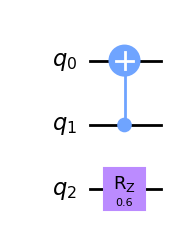

In [2]:
import random_circuit

circ1 = random_circuit.random_circuit(3, 1,[0.6])
circ1.draw('mpl')

In [125]:
num_qubits = 3
num_layers = 3
compiler = qtm.qcompilation.QuantumCompilation(
    # u = random_circuit.random_circuit(3, 4)
    u = qtm.ansatz.create_parameterized_polygongraph_ansatz(num_qubits, num_layers),
    vdagger = qtm.state.create_ghz_state(num_qubits).inverse(),
    optimizer = 'sgd',
    loss_func = 'loss_fubini_study',
    num_layers = num_layers
)
compiler.fit(num_steps = 10, verbose = 1)

Step:   0%|          | 0/10 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
Step: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


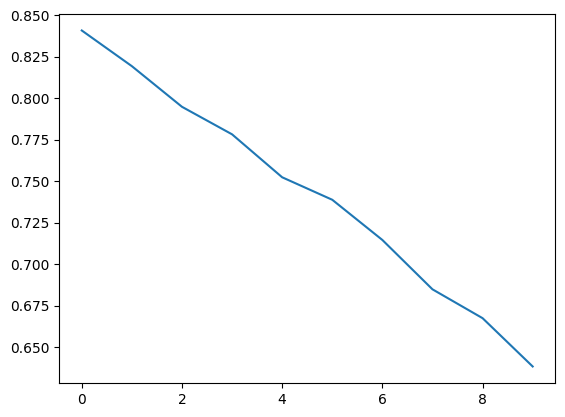

In [126]:
plt.plot(compiler.loss_values)

In [129]:
import numpy as np
import random

# Define the grid world environment
grid_world = [
    ['S', '.', '.', '.'],
    ['.', 'X', '.', 'X'],
    ['.', '.', '.', 'X'],
    ['.', 'X', '.', 'G']
]

# Define the action space: up, down, left, right
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# Define Q-value table (initialized with zeros)
q_table = np.zeros((4, 4, len(actions)))

# Hyperparameters
learning_rate = 0.1
discount_factor = 0.9
num_episodes = 1000
max_steps_per_episode = 100
# Q-learning algorithm
for episode in range(num_episodes):
    state = (0, 0)  # Starting state
    done = False
    steps = 0

    while not done and steps < max_steps_per_episode:
        # Choose an action using epsilon-greedy policy
        if random.random() > episode / num_episodes:
            action_idx = np.argmax(q_table[state])
        else:
            action_idx = random.randint(0, len(actions) - 1)

        action = actions[action_idx]
        next_state = (state[0] + action[0], state[1] + action[1])

        # Calculate the reward
        if next_state == (3, 3):  # Goal state
            reward = 1
            done = True
        elif next_state in [(1, 1), (2, 3), (3, 1)]:  # Obstacles
            reward = -1
            done = True
        else:
            reward = 0
            done = False

        # Update Q-value using the Q-learning formula
        if not done:  # Skip the Q-value update for terminal states
            q_table[state][action_idx] = (1 - learning_rate) * q_table[state][action_idx] \
                                         + learning_rate * (reward + discount_factor * np.max(q_table[next_state]))

        state = next_state
        steps += 1


IndexError: index -5 is out of bounds for axis 0 with size 4